In [2]:
library(dplyr)
library(ggplot2)
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}

In [3]:
library(Hmisc) 

Warning message:
"package 'Hmisc' was built under R version 3.5.2"Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units



In [4]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [5]:
### load data

wea22 <- read.csv(file="C:/Users/Chen/Project/data/wea22.csv")
head(wea22)

Station2,Date2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,PrecipTotal2,...,FU,GR,HZ,RA,SN,SQ,TS,TSRA,VCFG,VCTS
2,2007-05-01,84,52,33,51,26,1,4,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-05-02,60,43,17,42,16,6,1,0,...,0,0,1,0,0,0,0,0,0,0
2,2007-05-03,67,48,23,40,19,28,1,0,...,0,0,1,0,0,0,0,0,0,0
2,2007-05-04,78,51,NA,42,19,NA,NA,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-05-05,66,54,25,39,19,26,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-05-06,68,52,25,30,15,26,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
wea22$Date2 <- as.Date(wea22$Date2, format = "%Y-%m-%d")

In [7]:
wea22$ID <- seq.int(nrow(wea22))

In [8]:
wea22 <- wea22 %>%
  select(ID, everything())


In [9]:
head(wea22)

ID,Station2,Date2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,...,FU,GR,HZ,RA,SN,SQ,TS,TSRA,VCFG,VCTS
1,2,2007-05-01,84,52,33,51,26,1,4,...,0,0,0,0,0,0,0,0,0,0
2,2,2007-05-02,60,43,17,42,16,6,1,...,0,0,1,0,0,0,0,0,0,0
3,2,2007-05-03,67,48,23,40,19,28,1,...,0,0,1,0,0,0,0,0,0,0
4,2,2007-05-04,78,51,NA,42,19,NA,NA,...,0,0,0,0,0,0,0,0,0,0
5,2,2007-05-05,66,54,25,39,19,26,1,...,0,0,0,0,0,0,0,0,0,0
6,2,2007-05-06,68,52,25,30,15,26,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
var1<-c('Tmax2', 'Tmin2', 'Tavg2' ,'DewPoint2' ,'WetBulb2' ,'Heat2' ,'Cool2' ,'PrecipTotal2', 'StnPressure2', 'SeaLevel2', 'ResultSpeed2', 'ResultDir2' ,'AvgSpeed2')

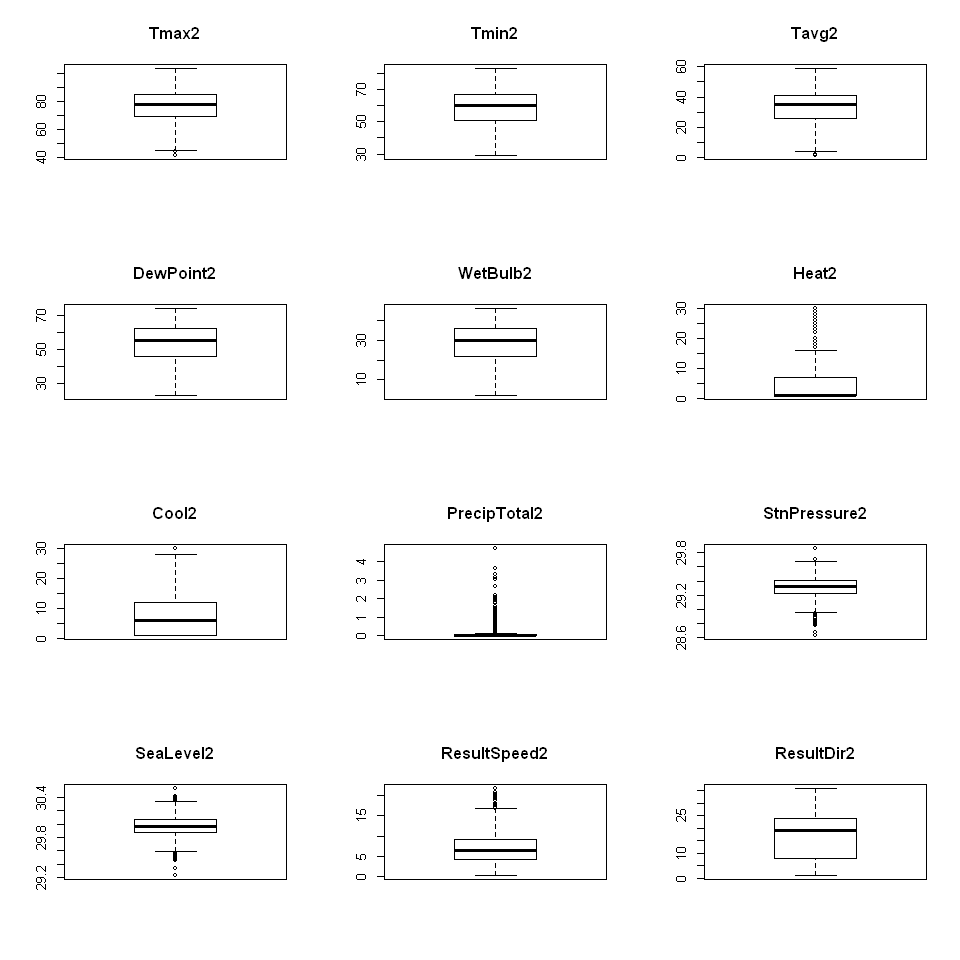

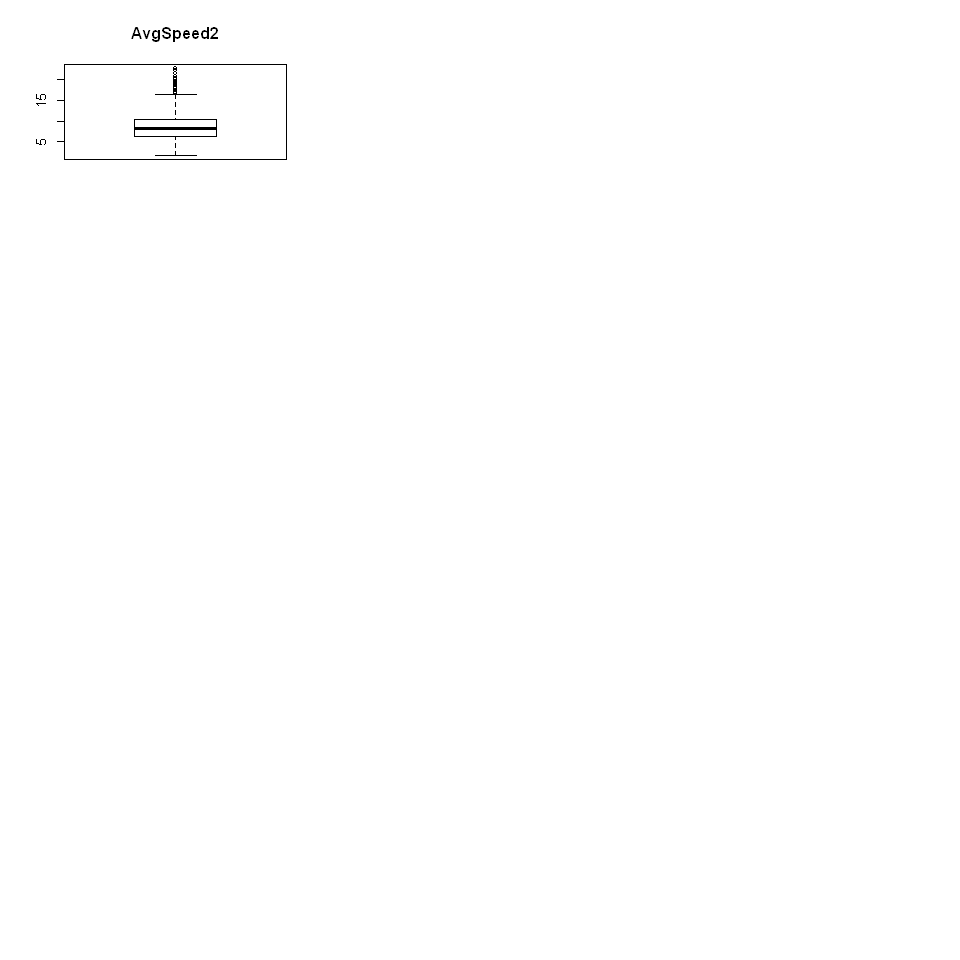

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(wea22[var1])) {
    boxplot(wea22[[v]],main=v)
}
par(mfrow=c(1,1))

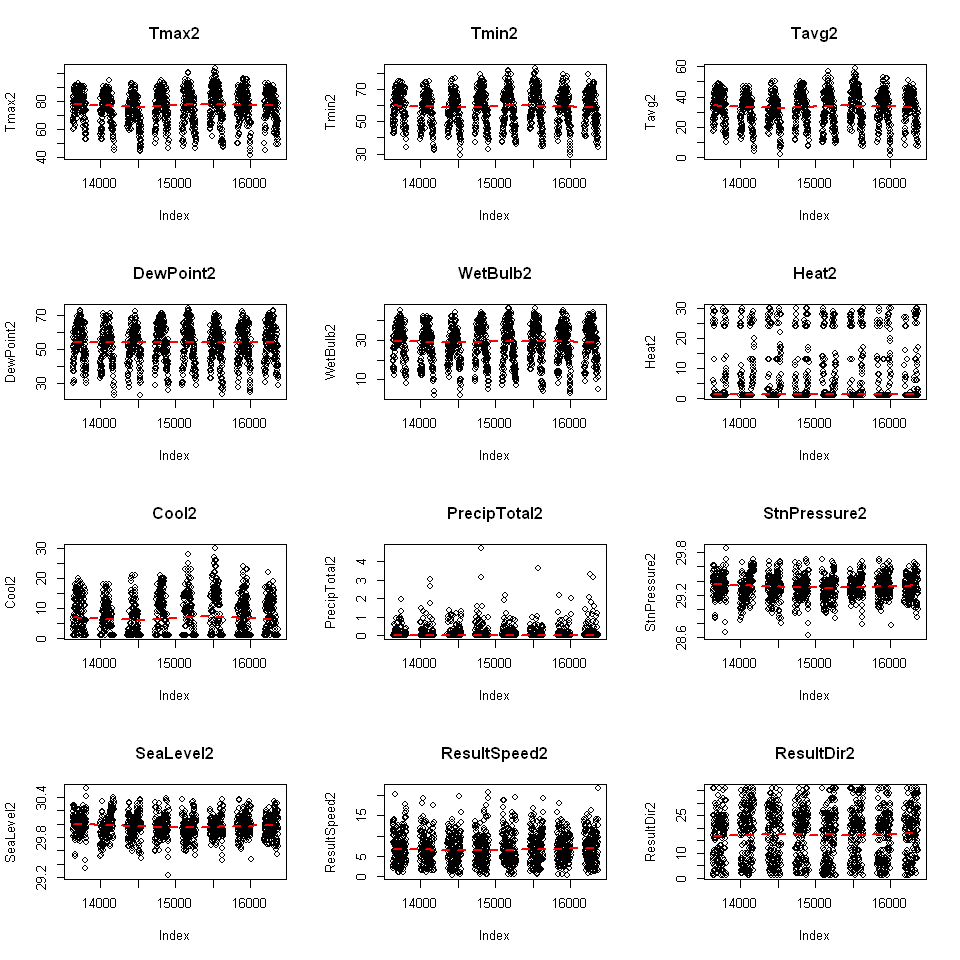

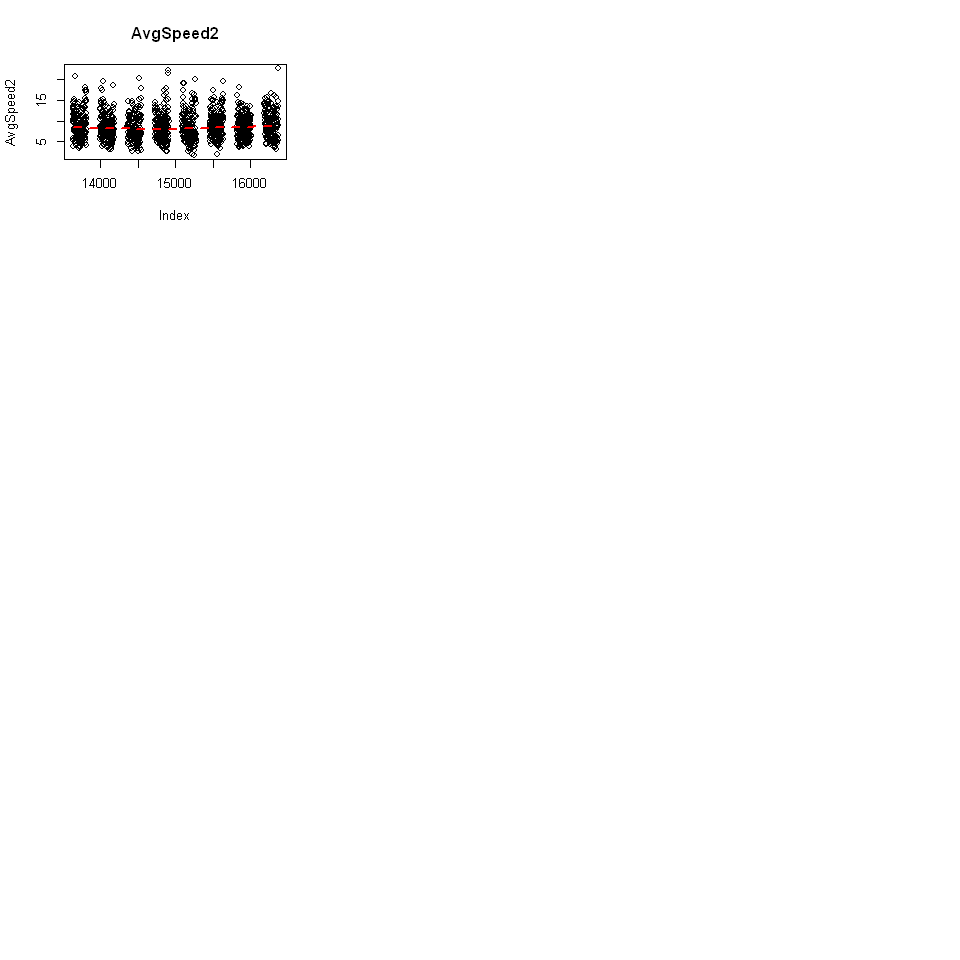

In [18]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(wea22[var1])) {
    scatter.smooth(wea22[[v]] ~ wea22$Date, main=v, xlab="Index",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2))
}
par(mfrow=c(1,1))

In [84]:
describe(wea22)

wea22 

 30  Variables      1472  Observations
--------------------------------------------------------------------------------
Station2 
       n  missing distinct     Info     Mean      Gmd 
    1472        0        1        0        2        0 
               
Value         2
Frequency  1472
Proportion    1
--------------------------------------------------------------------------------
Date2 
       n  missing distinct 
    1472        0     1472 

lowest : 2007-05-01 2007-05-02 2007-05-03 2007-05-04 2007-05-05
highest: 2014-10-27 2014-10-28 2014-10-29 2014-10-30 2014-10-31
--------------------------------------------------------------------------------
Tmax2 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    1472        0       61    0.999    76.35    12.84    54.55    60.00 
     .25      .50      .75      .90      .95 
   69.00    78.00    85.00    89.00    92.00 

lowest :  41  44  45  46  47, highest:  99 100 101 102 104
-----------------------------

In [11]:
head(missingMatrix(wea22))

ID,Station2,Date2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,...,FU,GR,HZ,RA,SN,SQ,TS,TSRA,VCFG,VCTS
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


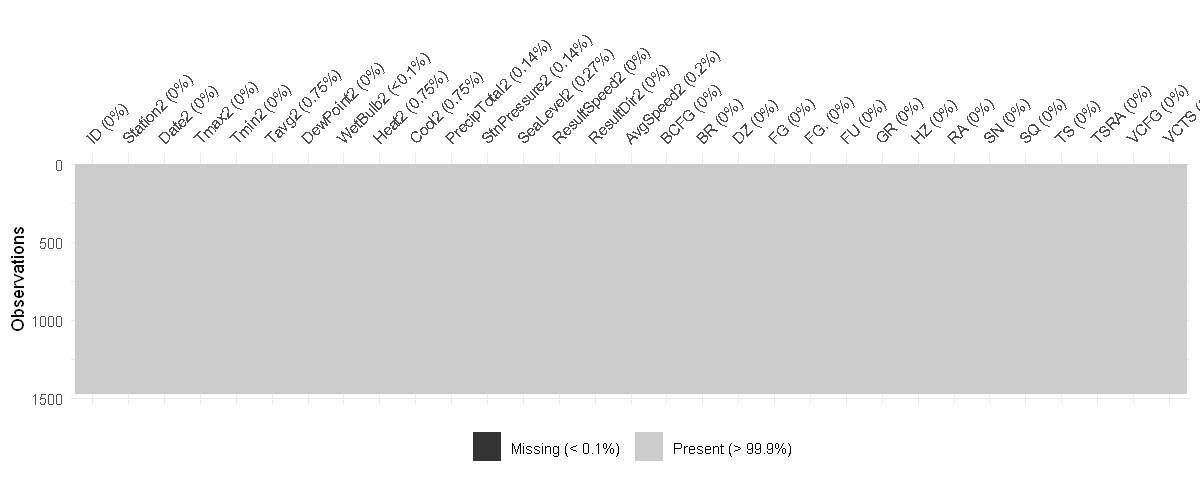

In [12]:
options(repr.plot.width = 10, repr.plot.height = 4)
vis_miss(wea22)

In [13]:
var2<-c('ID','Station2','Date2', 'Tmax2', 'Tmin2', 'Tavg2', 'DewPoint2', 'WetBulb2', 'Heat2', 'Cool2', 'PrecipTotal2' )

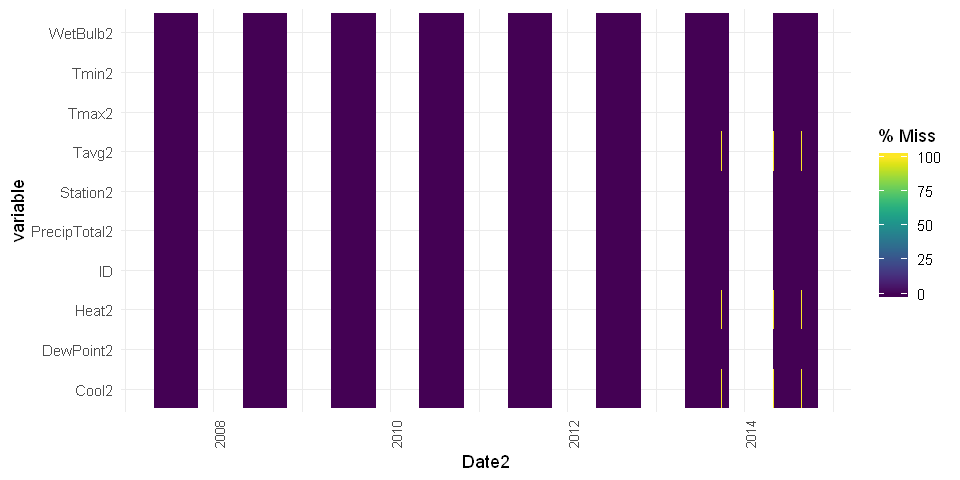

In [14]:
options(repr.plot.width = 8, repr.plot.height = 4)
gg_miss_fct(x=wea22[var2], fct=Date2) + 
theme(axis.text.x = element_text(angle=90, size=8))

Determinate the Missingness Generation Mechanism

In [87]:
colnames(wea22)

[1] "Station2"     "Date2"        "Tmax2"        "Tmin2"        "Tavg2"       
 [6] "DewPoint2"    "WetBulb2"     "Heat2"        "Cool2"        "PrecipTotal2"
[11] "StnPressure2" "SeaLevel2"    "ResultSpeed2" "ResultDir2"   "AvgSpeed2"   
[16] "BCFG"         "BR"           "DZ"           "FG"           "FG."         
[21] "FU"           "GR"           "HZ"           "RA"           "SN"          
[26] "SQ"           "TS"           "TSRA"         "VCFG"         "VCTS"

In [15]:
grep('Tavg2', colnames(wea22))

[1] 6

In [16]:
grep('PrecipTotal2', colnames(wea22))

[1] 11

In [17]:
# require(MissMech)
wea22m <- wea22[,c(1,4,6,11)]
miss1 <- TestMCARNormality(data=wea22m)
miss1

Call:
TestMCARNormality(data = wea22m)

Number of Patterns:  2 

Total number of cases used in the analysis:  1470 

 Pattern(s) used:
          ID   Tmax2   Tavg2   PrecipTotal2   Number of cases
group.1    1       1       1              1              1459
group.2    1       1      NA              1                11


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  2.335652e-13 

    Either the test of multivariate normality or homoscedasticity (or both) is rejected.
    Provided that normality can be assumed, the hypothesis of MCAR is 
    rejected at 0.05 significance level. 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0.1336018 

    Reject Normality at 0.05 significance level.
    There is not sufficient evidence to reject MCAR at 0.05 significance level.

In [18]:
miss1 <- TestMCARNormality(data=wea22m, , del.lesscases = 1, imputation.number = 10)
summary(miss1)



Number of imputation:  10 

Number of Patterns:  3 

Total number of cases used in the analysis:  1472 

 Pattern(s) used:
          ID   Tmax2   Tavg2   PrecipTotal2   Number of cases
group.1    1       1       1              1              1459
group.2    1       1      NA              1                11
group.3    1       1       1             NA                 2


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  1.399754e-12 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0.2515396 


In [20]:
summary(miss1$imputed.data)

wea22.imp <- data.frame(miss1$imputed.data)
idx <- miss1$caseorder

head(wea22.imp)
dim(wea22.imp)

       ID             Tmax2            Tavg2        PrecipTotal2   
 Min.   :   1.0   Min.   : 41.00   Min.   : 1.00   Min.   :0.0000  
 1st Qu.: 368.8   1st Qu.: 69.00   1st Qu.:26.00   1st Qu.:0.0000  
 Median : 736.5   Median : 78.00   Median :35.00   Median :0.0000  
 Mean   : 736.5   Mean   : 76.35   Mean   :32.91   Mean   :0.1286  
 3rd Qu.:1104.2   3rd Qu.: 85.00   3rd Qu.:41.00   3rd Qu.:0.0525  
 Max.   :1472.0   Max.   :104.00   Max.   :59.00   Max.   :4.7300  

ID,Tmax2,Tavg2,PrecipTotal2
1,84,33.00000,0
2,60,17.00000,0
3,67,23.00000,0
4,78,35.20733,0
5,66,25.00000,0
6,68,25.00000,0


[1] 1472    4

In [21]:
summary(wea22m)
head(wea22m)
dim(wea22m)

       ID             Tmax2            Tavg2        PrecipTotal2   
 Min.   :   1.0   Min.   : 41.00   Min.   : 1.00   Min.   :0.0000  
 1st Qu.: 368.8   1st Qu.: 69.00   1st Qu.:26.00   1st Qu.:0.0000  
 Median : 736.5   Median : 78.00   Median :35.00   Median :0.0000  
 Mean   : 736.5   Mean   : 76.35   Mean   :32.88   Mean   :0.1281  
 3rd Qu.:1104.2   3rd Qu.: 85.00   3rd Qu.:41.00   3rd Qu.:0.0500  
 Max.   :1472.0   Max.   :104.00   Max.   :59.00   Max.   :4.7300  
                                   NA's   :11      NA's   :2       

ID,Tmax2,Tavg2,PrecipTotal2
1,84,33,0
2,60,17,0
3,67,23,0
4,78,NA,0
5,66,25,0
6,68,25,0


[1] 1472    4

In [22]:
colnames(wea22.imp)[2] <- "Tmax2.imp"
colnames(wea22.imp)[3] <- "Tavg2.imp"
colnames(wea22.imp)[4] <- "PrecipTotal2.imp"

In [23]:
head(wea22.imp)
dim(wea22.imp)

ID,Tmax2.imp,Tavg2.imp,PrecipTotal2.imp
1,84,33.00000,0
2,60,17.00000,0
3,67,23.00000,0
4,78,35.20733,0
5,66,25.00000,0
6,68,25.00000,0


[1] 1472    4

In [24]:
head(wea22)
dim(wea22)

ID,Station2,Date2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,...,FU,GR,HZ,RA,SN,SQ,TS,TSRA,VCFG,VCTS
1,2,2007-05-01,84,52,33,51,26,1,4,...,0,0,0,0,0,0,0,0,0,0
2,2,2007-05-02,60,43,17,42,16,6,1,...,0,0,1,0,0,0,0,0,0,0
3,2,2007-05-03,67,48,23,40,19,28,1,...,0,0,1,0,0,0,0,0,0,0
4,2,2007-05-04,78,51,NA,42,19,NA,NA,...,0,0,0,0,0,0,0,0,0,0
5,2,2007-05-05,66,54,25,39,19,26,1,...,0,0,0,0,0,0,0,0,0,0
6,2,2007-05-06,68,52,25,30,15,26,1,...,0,0,0,0,0,0,0,0,0,0


[1] 1472   31

In [25]:
wea22<- merge(x = wea22, y = wea22.imp, by = "ID", all.x = TRUE)
head(wea22)
dim(wea22)

ID,Station2,Date2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,...,RA,SN,SQ,TS,TSRA,VCFG,VCTS,Tmax2.imp,Tavg2.imp,PrecipTotal2.imp
1,2,2007-05-01,84,52,33,51,26,1,4,...,0,0,0,0,0,0,0,84,33.00000,0
2,2,2007-05-02,60,43,17,42,16,6,1,...,0,0,0,0,0,0,0,60,17.00000,0
3,2,2007-05-03,67,48,23,40,19,28,1,...,0,0,0,0,0,0,0,67,23.00000,0
4,2,2007-05-04,78,51,NA,42,19,NA,NA,...,0,0,0,0,0,0,0,78,35.20733,0
5,2,2007-05-05,66,54,25,39,19,26,1,...,0,0,0,0,0,0,0,66,25.00000,0
6,2,2007-05-06,68,52,25,30,15,26,1,...,0,0,0,0,0,0,0,68,25.00000,0


[1] 1472   34

In [26]:
wea22.imp<-wea22

In [27]:
head(wea22.imp)
dim(wea22.imp)

ID,Station2,Date2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,...,RA,SN,SQ,TS,TSRA,VCFG,VCTS,Tmax2.imp,Tavg2.imp,PrecipTotal2.imp
1,2,2007-05-01,84,52,33,51,26,1,4,...,0,0,0,0,0,0,0,84,33.00000,0
2,2,2007-05-02,60,43,17,42,16,6,1,...,0,0,0,0,0,0,0,60,17.00000,0
3,2,2007-05-03,67,48,23,40,19,28,1,...,0,0,0,0,0,0,0,67,23.00000,0
4,2,2007-05-04,78,51,NA,42,19,NA,NA,...,0,0,0,0,0,0,0,78,35.20733,0
5,2,2007-05-05,66,54,25,39,19,26,1,...,0,0,0,0,0,0,0,66,25.00000,0
6,2,2007-05-06,68,52,25,30,15,26,1,...,0,0,0,0,0,0,0,68,25.00000,0


[1] 1472   34

In [28]:
write.csv(wea22.imp, file="C:/Users/Chen/Project/data/wea22.imp.csv", row.names =F)

In [ ]:
colnames(wea2) <- c(

In [29]:
grep('BCFG', colnames(wea22))

[1] 17

In [10]:
str(wea22)

'data.frame':	1472 obs. of  31 variables:
 $ ID          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Station2    : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Date2       : Date, format: "2007-05-01" "2007-05-02" ...
 $ Tmax2       : int  84 60 67 78 66 68 84 80 76 83 ...
 $ Tmin2       : int  52 43 48 51 54 52 50 60 63 59 ...
 $ Tavg2       : num  33 17 23 NA 25 25 32 35 35 36 ...
 $ DewPoint2   : int  51 42 40 42 39 30 39 57 60 52 ...
 $ WetBulb2    : num  26 16 19 19 19 15 22 32 32 30 ...
 $ Heat2       : num  1 6 28 NA 26 26 1 1 1 1 ...
 $ Cool2       : num  4 1 1 NA 1 1 3 6 6 7 ...
 $ PrecipTotal2: num  0 0 0 0 0 0 0 0 0.02 0 ...
 $ StnPressure2: num  29.2 29.4 29.5 29.4 29.5 ...
 $ SeaLevel2   : num  29.8 30.1 30.1 30 30.1 ...
 $ ResultSpeed2: num  2.7 13.3 12.9 10.1 11.2 13.8 8.5 2.5 3.9 2 ...
 $ ResultDir2  : int  25 2 6 7 7 10 17 8 7 9 ...
 $ AvgSpeed2   : num  9.6 13.4 13.2 10.4 11.5 14.5 9.9 5.4 5.9 3.9 ...
 $ BCFG        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ BR          : int  0 1 0 0 0 0 0 0 1 1 .